In [125]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [180]:
with open(DATAFOLDER / "snips_angvel.pickle", "rb") as f:
    snips_vel = dill.load(f)
    
with open(DATAFOLDER / "x_array_forDLC.pickle", "rb") as f:
    x_vel = dill.load(f)

snips_vel.shape

## pre-processing of the DLC angvel snips

# interpolation
df_snips_vel = pd.DataFrame(snips_vel)


df_interpolated = df_snips_vel.interpolate(method='linear', axis=1)
df_filled = df_interpolated.ffill(axis=1).bfill(axis=1)

snips_vel_processed = df_filled.to_numpy()

# find absolute
snips_vel_processed = np.abs(snips_vel_processed)

# zscore
def zscore(x, baseline_points=50):
    """
    Z-score normalization of a 2D array.
    :param x: 2D array
    :param baseline_points: number of points to use for baseline calculation
    :return: z-scored array
    """
    x = np.array(x)
    mean = np.nanmean(x[:, :baseline_points], axis=1)
    std = np.nanstd(x[:, :baseline_points], axis=1)
    print(np.min(std))
    zscored = (x - mean[:, None]) / std[:, None]
    return zscored

# snips_vel_processed = zscore(snips_vel_processed, baseline_points=50)

# how about instead of zscoring, we just adjust to baseline subtraction
baseline = np.nanmean(snips_vel_processed[:, :50], axis=1)
snips_vel_processed = snips_vel_processed - baseline[:, None]

print(np.sum(np.isnan(snips_vel_processed)))
snips_vel = np.array(snips_vel_processed)

# removing NaNs
rows_with_nans_mask = np.isnan(snips_vel).any(axis=1)
snips_vel = snips_vel[~rows_with_nans_mask]
x_vel = x_vel[~rows_with_nans_mask].reset_index(drop=True)
print(snips_vel.shape)
x_vel.shape

0
(1960, 200)


(1960, 6)

In [181]:
x_vel.index

RangeIndex(start=0, stop=1960, step=1)

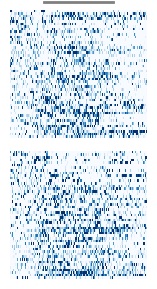

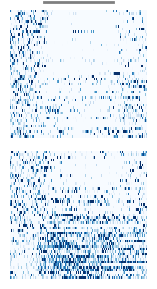

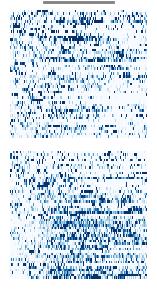

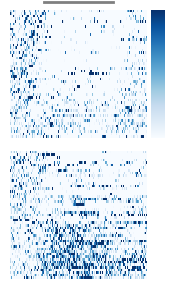

In [183]:
def get_heatmap_data(snips, x_array, condition, sex, infusiontype):
    if sex == "F" or sex == "M":
        query_string = "condition == @condition & sex == @sex & infusiontype == @infusiontype"
    else:
        query_string = "condition == @condition & infusiontype == @infusiontype"

    heatmap_data = []
    df = x_array.query(query_string)
    # print(df.head())
    for trial in df.trial.unique():
        tmp_snips = snips[x_array.query(query_string + " & trial == @trial").index]
        mean_snip = np.nanmean(tmp_snips, axis=0)
        heatmap_data.append(mean_snip)
        
    return np.array(heatmap_data)


def init_figure():
    f = plt.figure(figsize=(2, 3.5))
    gs = f.add_gridspec(2, 2, hspace=0.1, wspace=0.05, width_ratios=[10, 1])
    
    ax1 = f.add_subplot(gs[0, 0])
    ax2 = f.add_subplot(gs[1, 0])
    cbar_ax = f.add_subplot(gs[0, 1])
    
    return f, ax1, ax2, cbar_ax

def make_heatmap(data, ax, vlim, cbar_ax=None, inf_bar=False):
    
    if cbar_ax is not None:
        cbar=True
    else:
        cbar=False
        
    sns.heatmap(np.array(data),
                cmap="Blues",
                ax=ax,
                cbar=cbar,
                cbar_ax=cbar_ax,
                vmin=0, vmax=vlim
                )
    
    if cbar_ax is not None:
        cbar_ax.set_yticks([])
    
    if inf_bar:
        ax.plot([50,150], [-3, -3], color="black", lw=2, alpha=0.5, clip_on=False)
        
    ax.set_xticks([])
    ax.set_yticks([])

vlim = 5
# savefigs = False

# female, replete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_vel, "replete", "F", "10NaCl")
f_replete_10_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True)

heatmap_data = get_heatmap_data(snips_vel, x_vel, "replete", "F", "45NaCl")
f_replete_45_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim)

cbar_ax.remove()

if savefigs:
    f.savefig(FIGSFOLDER / "heatmap_vel_female_replete.pdf")

# # female, deplete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_vel, "deplete", "F", "10NaCl")
f_deplete_10_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True)

heatmap_data = get_heatmap_data(snips_vel, x_vel, "deplete", "F", "45NaCl")
f_deplete_45_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim)

cbar_ax.remove()

if savefigs:
    f.savefig(FIGSFOLDER / "heatmap_vel_female_deplete.pdf")

# # male, replete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_vel, "replete", "M", "10NaCl")
m_replete_10_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True)

heatmap_data = get_heatmap_data(snips_vel, x_vel, "replete", "M", "45NaCl")
m_replete_45_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim)

cbar_ax.remove()

if savefigs:
    f.savefig(FIGSFOLDER / "heatmap_vel_male_replete.pdf")

# # male, deplete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_vel, "deplete", "M", "10NaCl")
m_deplete_10_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True)

heatmap_data = get_heatmap_data(snips_vel, x_vel, "deplete", "M", "45NaCl")
m_deplete_45_inf = np.nanmean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim, cbar_ax=cbar_ax)

if savefigs:
    f.savefig(FIGSFOLDER / "heatmap_vel_male_deplete.pdf")


C:\Users\jmc010\AppData\Local\Temp\ipykernel_4328\2845107045.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc.append(np.trapz(snip[50:150]))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_4328\2845107045.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc.append(np.trapz(snip[50:150]))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_4328\2845107045.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc.append(np.trapz(snip[50:150]))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_4328\2845107045.py:50: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc.append(np.trapz(snip[50:150]))


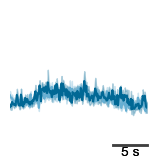

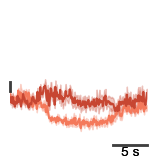

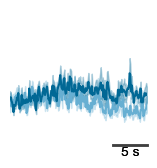

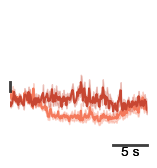

In [186]:
def get_mean_snips(snips, x_array, sex, condition):
    if sex.upper() == "F" or sex.upper() == "M":
        query_string = "condition == @condition & sex == @sex"
    else:
        query_string = "condition == @condition"

    snips_10, snips_45 = [], []
    for id in x_array.query(query_string + " & infusiontype == '10NaCl'").id.unique():
        snips_10.append(np.nanmean(snips[x_array.query(query_string + " & id == @id").index], axis=0))
    for id in x_array.query(query_string + " & infusiontype == '45NaCl'").id.unique():
        snips_45.append(np.nanmean(snips[x_array.query(query_string + " & id == @id").index], axis=0))
        
    return np.array(snips_10), np.array(snips_45)

def init_figure():
    f = plt.figure(figsize=(2, 2))
    gs = f.add_gridspec(1, 2, hspace=0.1, wspace=0.05, width_ratios=[10, 1], bottom=0.2)
    ax = f.add_subplot(gs[0, 0])
    
    return f, ax
    
def plot_snips(snips_10, snips_45, ax, colors_10, colors_45, ylims, scalebar=False):
    for snips, col in zip([snips_10, snips_45], [colors_10, colors_45]):
        x = np.arange(snips.shape[1]) / 10
        mean = np.mean(snips, axis=0)
        sd = np.std(snips, axis=0)
        sem = sd / np.sqrt(snips.shape[0])
        
        ax.plot(x, mean, color=col, lw=1.5)
        ax.fill_between(x, mean-sem, mean+sem, alpha=0.3, color=col)
        
        sns.despine(ax=ax, top=True, right=True, left=True, bottom=True)
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_xlim([0, 20])
        ax.set_ylim(ylims)
        ax.plot([15,20], [ylims[0], ylims[0]], color="black", lw=2, alpha=0.5, clip_on=False)
        ax.text(17.5, ylims[0]-0.1, "5 s", ha="center", va="top", fontsize=10)
        
        if scalebar:
            ax.plot([0, 0], [1, 2], color="black", lw=2, alpha=0.5, clip_on=False)
            
        # print(ax.get_ylim(), ax.get_xlim())
        
    
def get_auc(snips):
    auc = []
    for snip in snips:
        auc.append(np.trapz(snip[50:150]))
    return np.array(auc)

# savefigs = False
ylims = [-5, 10]

# female, replete
f, ax = init_figure()

snips_10, snips_45 = get_mean_snips(snips_vel, x_vel, "F", "replete")
plot_snips(snips_10, snips_45, ax, colors[0], colors[1], ylims)
f_replete_aucs = [get_auc(snips_10), get_auc(snips_45)]

if savefigs:
    f.savefig(FIGSFOLDER / "snips_vel_female_replete.pdf")

# female, deplete
f, ax = init_figure()

snips_10, snips_45 = get_mean_snips(snips_vel, x_vel, "F", "deplete")
plot_snips(snips_10, snips_45, ax, colors[2], colors[3], ylims, scalebar=True)
f_deplete_aucs = [get_auc(snips_10), get_auc(snips_45)]

if savefigs:
    f.savefig(FIGSFOLDER / "snips_vel_female_deplete.pdf")
    
# male, replete
f, ax = init_figure()

snips_10, snips_45 = get_mean_snips(snips_vel, x_vel, "M", "replete")
plot_snips(snips_10, snips_45, ax, colors[0], colors[1], ylims)
m_replete_aucs = [get_auc(snips_10), get_auc(snips_45)]

if savefigs:
    f.savefig(FIGSFOLDER / "snips_vel_male_replete.pdf")
    
# male, deplete
f, ax = init_figure()

snips_10, snips_45 = get_mean_snips(snips_vel, x_vel, "M", "deplete")
plot_snips(snips_10, snips_45, ax, colors[2], colors[3], ylims, scalebar=True)
m_deplete_aucs = [get_auc(snips_10), get_auc(snips_45)]

if savefigs:
    f.savefig(FIGSFOLDER / "snips_vel_male_deplete.pdf")

In [ ]:
## sexes pooled

f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_vel, "replete", "both", "10NaCl")
both_replete_10_inf = np.mean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True)

heatmap_data = get_heatmap_data(snips_vel, x_vel, "replete", "both", "45NaCl")
both_replete_45_inf = np.mean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim)

cbar_ax.remove()

# if savefigs:
#     f.savefig(FIGSFOLDER / "heatmap_female_replete.pdf", dpi=600, transparent=True)

# female, deplete
f, ax1, ax2, cbar_ax = init_figure()

heatmap_data = get_heatmap_data(snips_vel, x_vel, "deplete", "both", "10NaCl")
both_deplete_10_inf = np.mean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax1, vlim, inf_bar=True)

heatmap_data = get_heatmap_data(snips_vel, x_vel, "deplete", "both", "45NaCl")
both_deplete_45_inf = np.mean(heatmap_data[:,49:150], axis=1)
make_heatmap(heatmap_data, ax2, vlim)

cbar_ax.remove()

array([[0.79033573, 0.71926936, 0.68202478, 0.64266638, 0.64682422,
        0.67035431, 0.6130031 , 0.63393502, 0.63876929, 0.6413954 ,
        0.68579607, 0.58128622, 0.5938184 , 0.63465611, 0.62587494,
        0.56790411, 0.76304137, 0.68624435, 0.76419   , 0.63719436,
        0.66503062, 0.74183196, 0.61044526, 0.59448206, 0.54209306,
        0.67705885, 0.55644863, 0.59821144, 0.42968345, 0.5992862 ,
        0.75261044, 0.68232193, 0.88603898, 0.69706335, 0.68736179,
        0.5156951 , 0.5319869 , 0.57533586, 0.90673462, 0.78725073,
        0.84308609, 0.69766888, 0.70969464, 1.04532687, 0.79572197,
        0.67295353, 0.99697698, 0.71852606, 0.67525866, 0.65498719,
        0.65081495, 1.16917452, 0.96232051, 0.95785675, 0.90055648,
        1.13250151, 0.98283042, 0.99828926, 0.68234458, 0.90566074,
        0.87461528, 0.8430468 , 0.94237831, 0.6962552 , 1.06840648,
        1.01804107, 1.04287064, 0.80738955, 0.67947708, 0.83823767,
        0.65014003, 0.69338767, 0.86977709, 0.76

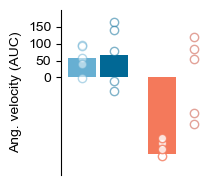

In [191]:
f, ax = plt.subplots(figsize=(2.2, 2.2),
                     gridspec_kw={"left": 0.25, "right": 0.95, "top": 0.95, "bottom": 0.2})


aucs = [f_replete_aucs, f_deplete_aucs]
barx = [1, 2]
barwidth=0.35

spacer = 0.2
ax.bar(barx[0] - spacer, np.mean(aucs[0][0]), color=colors[0], width=barwidth)
ax.bar(barx[0] + spacer, np.mean(aucs[0][1]), color=colors[1], width=barwidth)

ax.bar(barx[1] - spacer, np.mean(aucs[1][0]), color=colors[2], width=barwidth)
ax.bar(barx[1] + spacer, np.mean(aucs[1][1]), color=colors[3], width=barwidth)

ax.scatter([barx[0] - spacer]*len(aucs[0][0]), aucs[0][0], facecolors="white", edgecolors=colors[0], alpha=0.5)
ax.scatter([barx[0] + spacer]*len(aucs[0][1]), aucs[0][1], facecolors="white", edgecolors=colors[1], alpha=0.5)
ax.scatter([barx[1] - spacer]*len(aucs[1][0]), aucs[1][0], facecolors="white", edgecolors=colors[2], alpha=0.8)
ax.scatter([barx[1] + spacer]*len(aucs[1][1]), aucs[1][1], facecolors="white", edgecolors=colors[3], alpha=0.5)

sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
ax.set_xticks([])
ax.set_yticks([-0, 50, 100, 150])
ax.set_ylim([-290,200])

ax.set_ylabel("Ang. velocity (AUC)", fontsize=10)

if savefigs:
    f.savefig(FIGSFOLDER / "aucs_vel_female.pdf")

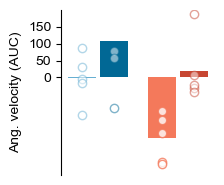

In [192]:
f, ax = plt.subplots(figsize=(2.2, 2.2),
                     gridspec_kw={"left": 0.25, "right": 0.95, "top": 0.95, "bottom": 0.2})


aucs = [m_replete_aucs, m_deplete_aucs]
barx = [1, 2]
barwidth=0.35

spacer = 0.2
ax.bar(barx[0] - spacer, np.mean(aucs[0][0]), color=colors[0], width=barwidth)
ax.bar(barx[0] + spacer, np.mean(aucs[0][1]), color=colors[1], width=barwidth)

ax.bar(barx[1] - spacer, np.mean(aucs[1][0]), color=colors[2], width=barwidth)
ax.bar(barx[1] + spacer, np.mean(aucs[1][1]), color=colors[3], width=barwidth)

ax.scatter([barx[0] - spacer]*len(aucs[0][0]), aucs[0][0], facecolors="white", edgecolors=colors[0], alpha=0.5)
ax.scatter([barx[0] + spacer]*len(aucs[0][1]), aucs[0][1], facecolors="white", edgecolors=colors[1], alpha=0.5)
ax.scatter([barx[1] - spacer]*len(aucs[1][0]), aucs[1][0], facecolors="white", edgecolors=colors[2], alpha=0.8)
ax.scatter([barx[1] + spacer]*len(aucs[1][1]), aucs[1][1], facecolors="white", edgecolors=colors[3], alpha=0.5)

sns.despine(ax=ax, top=True, right=True, left=False, bottom=True)
ax.set_xticks([])
ax.set_yticks([-0, 50, 100, 150])
ax.set_ylim([-290,200])

ax.set_ylabel("Ang. velocity (AUC)", fontsize=10)

if savefigs:
    f.savefig(FIGSFOLDER / "aucs_vel_male.pdf")

r = 0.17, p = 0.247
r = 0.47, p = 0.001
r = 0.20, p = 0.169
r = 0.70, p = 0.000
r = -0.20, p = 0.170
r = 0.32, p = 0.024
r = 0.62, p = 0.000
r = 0.36, p = 0.011


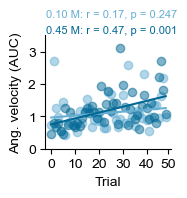

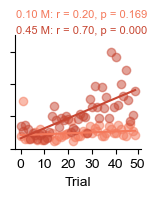

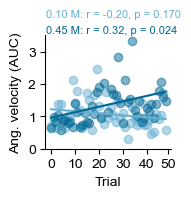

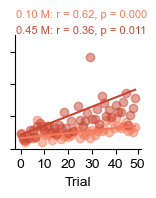

In [78]:
savefigs = True

def draw_regression_line(y, ax, color):
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    y_fit = slope * x + intercept
    ax.plot(x, y_fit, color=color, lw=1.5)
    
    print(f"r = {r_value:.2f}, p = {p_value:.3f}")
    
    return r_value, p_value

def make_correlation_plot(inf10, inf45, col10, col45, yaxis=False):
    
    f, ax = plt.subplots(figsize=(1.8,1.8),
                         gridspec_kw={"left": 0.25, "right": 0.95, "top": 0.85, "bottom": 0.22})

    ax.scatter(np.arange(len(inf10)), inf10, color=col10, alpha=0.5)
    ax.scatter(np.arange(len(inf45)), inf45, color=col45, alpha=0.5)

    r, p = draw_regression_line(inf10, ax, col10)
    ax.text(-2, 4, f"0.10 M: r = {r:.2f}, p = {p:.3f}", color=col10, fontsize=8,
            va="bottom", ha="left")
    r, p = draw_regression_line(inf45, ax, col45)
    ax.text(-2, 3.5, f"0.45 M: r = {r:.2f}, p = {p:.3f}", color=col45, fontsize=8,
            va="bottom", ha="left")

    sns.despine(ax=ax)

    ax.set_ylim([0, 3.5])
  
    if yaxis:
        ax.set_yticks([0, 1, 2, 3])
        ax.set_ylabel("Ang. velocity (AUC)")
    else:
        ax.set_yticks([0, 1, 2, 3], labels=["", "", "", ""])

    ax.set_xticks([0, 10, 20, 30, 40, 49], labels=["0", "10", "20", "30", "40", "50"])
    ax.set_xlabel("Trial")
    
    return f
    
f = make_correlation_plot(f_replete_10_inf, f_replete_45_inf, colors[0], colors[1], yaxis=True)
if savefigs:
    f.savefig(FIGSFOLDER / "correlation_vel_f_replete.pdf")
    
f = make_correlation_plot(f_deplete_10_inf, f_deplete_45_inf, colors[2], colors[3])
if savefigs:
    f.savefig(FIGSFOLDER / "correlation_vel_f_deplete.pdf")
    
f = make_correlation_plot(m_replete_10_inf, m_replete_45_inf, colors[0], colors[1], yaxis=True)
if savefigs:
    f.savefig(FIGSFOLDER / "correlation_vel_m_replete.pdf")
    
f = make_correlation_plot(m_deplete_10_inf, m_deplete_45_inf, colors[2], colors[3])
if savefigs:
    f.savefig(FIGSFOLDER / "correlation_vel_m_deplete.pdf")


In [80]:
with open(DATAFOLDER / "snips_photo_forDLC.pickle", "rb") as f:
    snips = dill.load(f)


In [82]:
snips.shape

(1960, 200)

In [85]:
auc_snips = snips[:, 50:150].mean(axis=1)
auc_vel = snips_vel[:, 50:150].mean(axis=1)
auc_vel.shape, auc_snips.shape

((1960,), (1960,))

(0.0, 5.0)

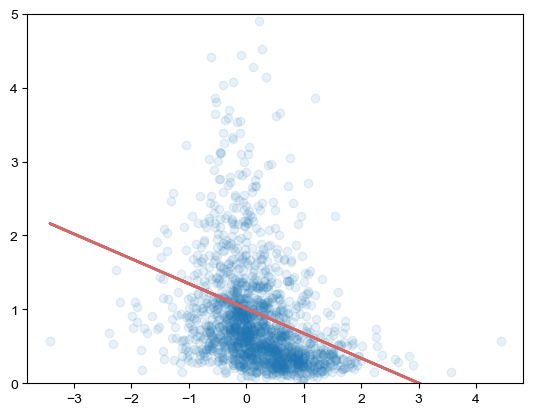

In [109]:
df = pd.DataFrame({"auc_snips": auc_snips, "auc_vel": auc_vel}).dropna(axis='rows')

f, ax = plt.subplots()
ax.scatter(df.auc_snips, df.auc_vel, alpha=0.1)

x = df.auc_snips
y = df.auc_vel
color = "#D26769"

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_fit = slope * x + intercept
ax.plot(x, y_fit, color=color, lw=2)

ax.set_ylim([0, 5])

In [111]:
slope, intercept, r_value, p_value, std_err

(np.float64(-0.3364407945882233),
 np.float64(1.0121750270622034),
 np.float64(-0.18862016547864435),
 np.float64(2.653916128968383e-15),
 np.float64(0.042163221379347395))

In [106]:
df = pd.DataFrame({"auc_snips": auc_snips, "auc_vel": auc_vel})

In [113]:
df2 = pd.concat([x_vel, df], axis=1)

In [115]:
df2.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'cluster', 'sex',
       'auc_snips', 'auc_vel'],
      dtype='object')

In [99]:
df.dropna?

Signature:
df.dropna(
    *,
    axis: 'Axis' = 0,
    how: 'AnyAll | lib.NoDefault' = <no_default>,
    thresh: 'int | lib.NoDefault' = <no_default>,
    subset: 'IndexLabel | None' = None,
    inplace: 'bool' = False,
    ignore_index: 'bool' = False,
) -> 'DataFrame | None'
Docstring:
Remove missing values.

See the :ref:`User Guide <missing_data>` for more on which values are
considered missing, and how to work with missing data.

Parameters
----------
axis : {0 or 'index', 1 or 'columns'}, default 0
    Determine if rows or columns which contain missing values are
    removed.

    * 0, or 'index' : Drop rows which contain missing values.
    * 1, or 'columns' : Drop columns which contain missing value.

    Only a single axis is allowed.

how : {'any', 'all'}, default 'any'
    Determine if row or column is removed from DataFrame, when we have
    at least one NA or all NA.

    * 'any' : If any NA values are present, drop that row or column.
    * 'all' : If all values are NA, d

In [117]:
with open(DATAFOLDER / "snips_angvel.pickle", "rb") as f:
    snips_vel = dill.load(f)

In [120]:
np.nanmax(snips_vel), np.nanmin(snips_vel)

(np.float64(285.46950697796836), np.float64(8.318495145068383e-07))